## Imports

In [1]:
from pettingzoo.atari import surround_v2
import supersuit

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np

from tqdm import tqdm
import pickle
import random

from collections import deque

import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display


/home/ale/dlgs/tournamentVenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Making the environment

In [2]:
def plot(env):  #, agent, action, idx):
    screen = env.render()
    plt.imshow(screen)
    plt.show()
    #plt.title(f"{idx}, {agent}, {action}")

def get_env(render: bool):
    if render:
        env = surround_v2.env(render_mode="human")
    else:
        env = surround_v2.env(render_mode="rgb_array")
    env = supersuit.max_observation_v0(env, 2)
    # env = supersuit.sticky_actions_v0(env, repeat_action_probability=0.25)
    env = supersuit.frame_skip_v0(env, 4)
    env = supersuit.resize_v1(env, 84, 84)
    # env = supersuit.frame_stack_v1(env, 4)
    return env


# display = Display(visible=0, size=(400, 300))
# display.start()

## Agents

In [3]:
class Agent():
    def __init__(self, env, agent):
        self.action_space = env.action_space(agent)
        self.observation_space = env.observation_space(agent)
        self.agent = agent
        self.wins = 0
        self.losses = 0

    def get_action(self, obs):
        pass

    def remember(self, state, action, reward, next_state, done):
        if reward > 0:
            self.wins+=1
        elif reward < 0:
            self.losses += 1

    def restart_w_and_l(self):
        self.wins = 0
        self.losses = 0

    def replay(self, batch_size):
        pass

    def canReplay(self, batch_size):
        return False

### RandomAgent

In [4]:
class RandomAgent(Agent):
    def __init__(self, env, agent):
        super(RandomAgent, self).__init__(env, agent)

    def get_action(self, obs):
        return self.action_space.sample()

### DeepReinforcementLearning Agent

#### - Model

In [5]:
class Model(nn.Module):
    def __init__(self, action_space: int, observation_space):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5, padding=2, stride = 1)  
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 1, kernel_size = 3, stride = 1)  

        self.dense1 = nn.Linear(1*20*20, 500)    
        self.dense2 = nn.Linear(500, 250)    
        self.dense3 = nn.Linear(250, action_space)        

    def forward(self, x:torch.Tensor): 
        x = x.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
        x = self.conv1(x)   
        x = self.pool(F.relu(x))      
        x = self.conv2(x)     
        x = self.pool(F.relu(x))      
        # x = x.flatten()
        x = x.view(-1, 1*20*20)
        x = self.dense1(x)             
        x = F.relu(x)                  
        x = self.dense2(x) 
        x = F.relu(x)                  
        x = self.dense3(x) 
        return x

    def predict(self, x):              
        x = self.forward(x)     
        return torch.argmax(x, dim=1)

In [6]:
def stepValue(colorSum):
    if colorSum < 280:
        return 2 # [255,255,255]  # right player
    elif colorSum < 365:
        return 0 # [0,0,0]        # background
    elif colorSum < 380:
        return 1 # [255,0,0]      # left player
    else:
        return 3 # [0,0,255]      # walls

vecStepValue = np.vectorize(stepValue)

def encode(state):
    state = np.array(state)
    colorSum = np.sum(state, axis=-1)
    colorValues = vecStepValue(colorSum)
    colorValues = torch.as_tensor(colorValues, dtype=torch.float32)

    #colorValues = torch.tensor([stepValue(sum(color)) for row in state for color in row],
    # dtype=torch.float32)

    return colorValues.view((1,84,84))

def encodeMulti(states):
    encoded = torch.stack([encode(state) for state in states])
    encoded = encoded.view((-1,1,84,84))
    return encoded

#### - Agent

In [7]:
class AlebaGiogAgent(Agent):
    def __init__(self, env, agent):
        super(AlebaGiogAgent, self).__init__(env, agent)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = Model(action_space = self.action_space.n, observation_space = self.observation_space)
        
        self.model = self.model.to(self.device)

        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)

        self.memory = deque()

        self.gamma = 0.9
        
    def get_action(self, obs):
        obs = encode(obs)
        obs = obs.to(self.device)
        result = self.model.predict(obs)
        return result.item()

    def remember(self, state, action, reward, next_state, done):
        if reward > 0:
            self.wins += 1
        elif reward < 0:
            self.losses += 1
        
        if len(self.memory) >= 1000:
            self.memory.popleft()
        self.memory.append({"state" : state, 
                            "action" : action, 
                            "reward" : reward, 
                            "next_state" : next_state,
                            "done" : done})

    # def preprocess(self, obs):
    #     obs = torch.tensor(obs, dtype=torch.float32) / 255
    #     obs = obs.view(-1, 3, 84, 84)
    #     return obs

    def canReplay(self, batch_size):
        return len(self.memory) >= batch_size

    def replay(self, batch_size=64):
        batch = np.random.choice(self.memory, batch_size)
        self.train(batch)

    def train(self,batch):
        self.optimizer.zero_grad()              # clean gradients of parameters

        idxs = np.arange(len(batch))

        states = [tup["state"] for tup in batch]
        new_states = [tup["next_state"] for tup in batch]

        states = encodeMulti(states)
        new_states = encodeMulti(new_states)

        actions = torch.tensor([tup["action"] for tup in batch])
        rewards = torch.tensor([tup["reward"] for tup in batch])

        states.to(self.device)
        new_states.to(self.device)
        actions.to(self.device)
        rewards.to(self.device)

        predictions = self.model(states)[idxs, actions] # make prediction
        predictions = predictions.to(self.device)
        
        y = self.model(new_states)                          # It should be rewards[id] + self.gamma*.... but r is always 0 in this case
        q_target = torch.tensor([rewards[id] if rewards[id] != 0 else self.gamma * torch.max(y[id]) for id in idxs], dtype=torch.float32)     
        q_target = q_target.to(self.device)    
        loss = self.criterion(q_target, predictions)          # calculate loss with respect to prediction
        loss.backward()                         # calculate gradients of model.parameters() with respect to loss
        self.optimizer.step() 

## Training loop

In [8]:
env = get_env(render=False)
env.reset()

agents = {
    env.agents[0] : AlebaGiogAgent(env, env.agents[0]),
    env.agents[1] : RandomAgent(env, env.agents[1])
}
env.close()

In [9]:
def train(env, episodes, batch_size = 64, eps_start = 1):
    epsilon = eps_start
    delta_eps = eps_start / episodes
    for i in tqdm(range(episodes)):
        epsilon -= delta_eps
        env.reset()
        old_state, _, _, _, _ = env.last()
        action = 0
        agent_id = env.agent_selection
        agent = agents[agent_id]

        moves=0
        for agent_id in env.agent_iter():
            moves+=1
            # 1. Update state
            state, reward, done, _, _ = env.last()
            # 2. Have the agent remember stuff: the reward is inverted because is the one of the other agent
            agent.remember(old_state, action, -reward, state, done)

            if done:
                break

            # Update the agent
            agent = agents[agent_id]
            
            # 3. Make a move in game.
            tradeoff = random.uniform(0,1)
            if tradeoff > epsilon:
                action = agent.get_action(state)
            else:
                action = agent.action_space.sample()
                
            # Take the action
            env.step(action)
            # 4. save last state
            old_state = state
            
            if moves%9 == 0 or moves%10 == 0:
                # 5. if we have enough experiences in our memory, learn from a batch with replay.
                if agent.canReplay(batch_size):
                    agent.replay(batch_size)


In [10]:
env = get_env(render=False)
env.reset()

train(env, 50, 16)
print("--- first train session finished, wins:", agents[env.agents[0]].wins, " /  losses:", agents[env.agents[0]].losses)
agents[env.agents[0]].restart_w_and_l()
torch.save(agents[env.agents[0]].model.state_dict(), 'modelTournament.pth')
train(env, 50, 16, 0.8)
print("--- second train session finished, wins:", agents[env.agents[0]].wins, " /  losses:", agents[env.agents[0]].losses)
agents[env.agents[0]].restart_w_and_l()
torch.save(agents[env.agents[0]].model.state_dict(), 'modelTournament.pth')
train(env, 100, 32, 0.6)
print("--- third train session finished, wins:", agents[env.agents[0]].wins, " /  losses:", agents[env.agents[0]].losses)
agents[env.agents[0]].restart_w_and_l()
torch.save(agents[env.agents[0]].model.state_dict(), 'modelTournament.pth')
train(env, 100, 32, 0.6)
print("--- fourth train session finished, wins:", agents[env.agents[0]].wins, " /  losses:", agents[env.agents[0]].losses)
agents[env.agents[0]].restart_w_and_l()
torch.save(agents[env.agents[0]].model.state_dict(), 'modelTournament.pth')
train(env, 200, 64, 0.5)
print("--- fifth train session finished, wins:", agents[env.agents[0]].wins, " /  losses:", agents[env.agents[0]].losses)

env.close()
torch.save(agents[env.agents[0]].model.state_dict(), 'modelTournament.pth')

100%|██████████| 50/50 [14:04<00:00, 16.90s/it]


--- first train session finished, wins: 384  /  losses: 309


100%|██████████| 50/50 [14:24<00:00, 17.29s/it]


--- second train session finished, wins: 396  /  losses: 294


100%|██████████| 100/100 [44:46<00:00, 26.86s/it]


--- third train session finished, wins: 808  /  losses: 536


100%|██████████| 100/100 [43:48<00:00, 26.29s/it]


--- fourth train session finished, wins: 796  /  losses: 534


100%|██████████| 200/200 [2:36:56<00:00, 47.08s/it]  

--- fifth train session finished, wins: 1566  /  losses: 1157


In [11]:
env.close()

## Test the model

In [11]:
def play(agents):
    env = get_env(render = True)
    env.reset()
    for agent_id in env.agent_iter():
        agent = agents[agent_id]
        state, _, done, _, _ = env.last()
        if done:
            break
        action = agent.get_action(state)
        env.step(action)
    env.close()

play(agents)

# Plot to understand features

In [ ]:
env = get_env(render = False)
env.reset()
state, _, _, _, _ = env.last()
env.step(1)
env.close()

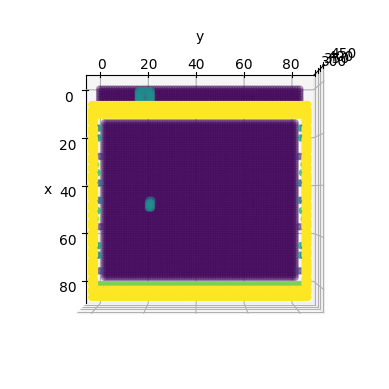

In [ ]:
def plotColors(state):
    fig = plt.figure()
    ax = plt.axes(projection='3d')

    x = np.array([i for i in range(len(state))]*len(state))
    y = np.array([[i]*len(state) for i in range(len(state[0]))])
    y = y.flatten()
    z = np.array([sum(state[xi][yi]) for xi,yi in zip(x,y)])

    ax.scatter3D(x, y, z, c=z, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    # ax.view_init(90, 0)

plotColors(state)

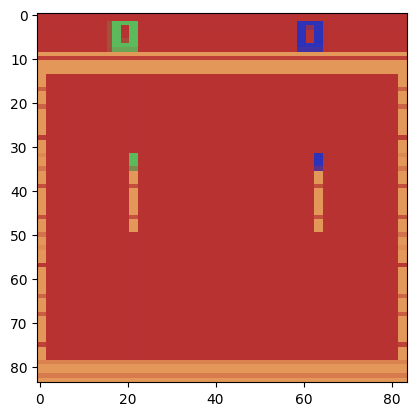

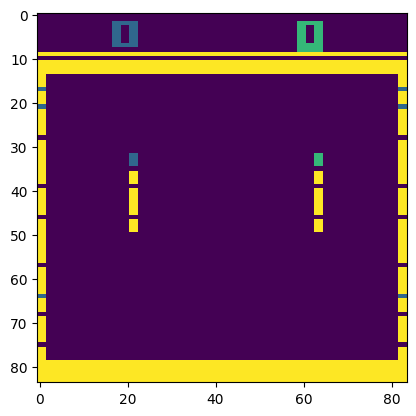

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3]])

In [ ]:
def encode(state):
    filtered_state = np.zeros((state.shape[0],state.shape[1]), dtype=int)
    for i,row in enumerate(state):
        for j,color in enumerate(row):
            if sum(color) < 280:
                filtered_state[i][j] = 2 # [255,255,255]  # right player
            elif sum(color)< 365:
                filtered_state[i][j] = 0 # [0,0,0]        # background
            elif sum(color)< 380:
                filtered_state[i][j] = 1 # [255,0,0]      # left player
            else:
                filtered_state[i][j] = 3 # [0,0,255]      # walls
    return filtered_state

filtered_state = encode(state)
plt.imshow(state)
plt.show()

plt.imshow(filtered_state)
plt.show()
filtered_state